# 9. Variational Autoencoder

In [2]:
from torch.autograd import Variable
%matplotlib inline

from utils.draw_utils import plot_digits

import torch
import torch.nn as nn

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Lambda, Compose

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import numpy as np


torch.manual_seed(1337) 
batch_size = 64 
transforms = Compose([ToTensor(), Lambda(lambda x: x.flatten())])

# Mnist dataset
train_data = MNIST(root='./data/', 
                   train=True, 
                   transform=transforms,    
                   download=True) # change to false if you already have the data

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

### Zadanie 1. VAE

Zaimplementować VAE, nadbudowując kod z ostatnich zajęć. Autoenkoder powinien składać się z warstw liniowych (z nieliniową aktywacją np. `tanh`) w enkoderze: 
   * wejściowa (rozmiar cyfry z MNISTA)
   * rozmiaru 128
   * rozmiaru 64
   * rozmiaru 12
   * 2 warstw rozmiaru `latent_dim` odpowiadająych średniej $\mu$ i wariancji $\Sigma$
   
oraz reparametryzacji obliczającej $z$ na podstawie $\mu$ i $\Sigma$, oraz dekodera z dokładnie odwrotnym przekształceniem.

In [19]:
class VAE(torch.nn.Module):
    
    def __init__(self, latent_dim):        
        super(VAE, self).__init__()        
        mnist_dim= 784        
        
        self.encoder = nn.Sequential(
            nn.Linear(mnist_dim,128),
            nn.Tanh(),
            nn.Linear(128,64),
            nn.Tanh(),
            nn.Linear(64,12),
            nn.Tanh(),            
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim,12),
            nn.Tanh(),
            nn.Linear(12,64),
            nn.Tanh(),
            nn.Linear(64,128),
            nn.Tanh(),
            nn.Linear(128,mnist_dim),
            nn.Sigmoid(),           
        )
        
        self.mu_layer = nn.Linear(12, latent_dim)
        self.var_layer = nn.Linear(12, latent_dim)
        
    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar) 
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decode(self, z):
        return self.decoder(z)
    
    def encode(self, x):
        encoded = self.encoder(x)
        return self.mu_layer(encoded), self.var_layer(encoded)

    def forward(self, x):
        mu, var = self.encode(x)
        z = self.reparametrize(mu, var)
        return self.decode(z), mu, var

## Zadanie 2: Pętla Uczenia

Uzupełnić brakujące fragmenty kodu uczenia oraz funkcji kosztu.

Epoch:  0 | train loss: 34769.6094
Epoch:  0 | train loss: 14138.9023
Epoch:  5 | train loss: 11471.5752
Epoch:  5 | train loss: 11225.1953
Epoch:  9 | train loss: 11601.6162
Epoch:  9 | train loss: 10983.0303


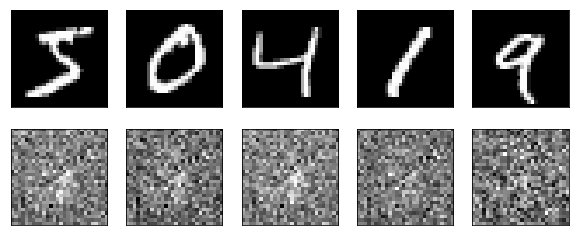

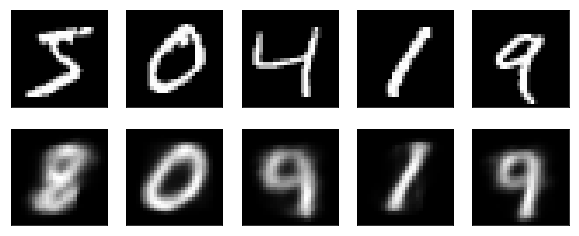

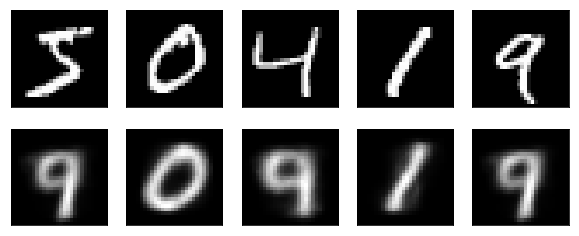

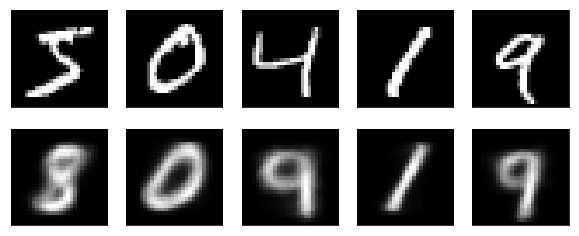

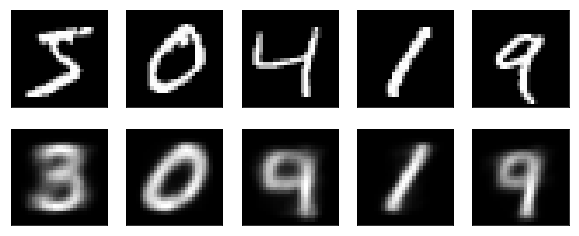

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): Tanh()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
  (mu_layer): Linear(in_features=12, out_features=3, bias=True)
  (var_layer): Linear(in_features=12, out_features=3, bias=True)
)

In [23]:
# Hyper Parameters
epochs = 10
LR = 0.005         # learning rate
n_plots = 5
latent_dim = 3 

# prepare original data for plotting
view_data = train_data.data[:n_plots].view(-1, 28*28).type(torch.FloatTensor) / 255.

autoencoder = VAE(latent_dim = latent_dim)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)

def loss_func(x_decoded, x, z_mu, z_var):
    BCE = torch.nn.functional.binary_cross_entropy(x_decoded, x, reduction='sum')
    KLD = 0.5 * torch.sum(z_var.exp() + z_mu.pow(2) - 1 - z_var)
    return BCE + KLD
autoencoder.train()
for epoch in range(epochs):
    for step, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()
        decoded, mu, var = autoencoder(x)

        loss = loss_func(decoded, x, mu, var) # calculate loss
        optimizer.zero_grad()   # clear gradients for this training step
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients

        if step % 500 == 0 and epoch in [0, 5, epochs -1]:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.item())

            # plotting decoded image (second row)
            decoded_data, _, _ = autoencoder(view_data)            
            plot_digits(view_data, decoded_data)
            
autoencoder.eval()

## Wizualizacja warstwy ukrytej

In [24]:
%matplotlib inline

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for step, (x, y) in enumerate(train_loader):                                                                                    
    z = autoencoder(x)[0].detach().numpy()
    ax.scatter(z[:, 0], z[:, 1], z[:, 2], c = y)
    if step == 10:
        break
plt.show()

## Zadanie 3: Generowanie

Wylosować 5 punktów z rozkładu N(0,1) i wygenerować z nich cyfry MNIST przy pomocy dekodera. Teraz już nie musimy liczyć statystyk latent space'a, bo znamy rozkład zmiennej $z$.

In [29]:
%matplotlib inline

z_sampled = torch.randn(5, latent_dim)  # sample 5 points in the latent space
x_decoded = autoencoder.decode(z_sampled) # decode the sampled points

plot_digits(x_decoded)

## Zadanie 4: Interpolacja

Analogicznie do przykładu z poprzednich zajęć pokazać interpolację między cyframi.

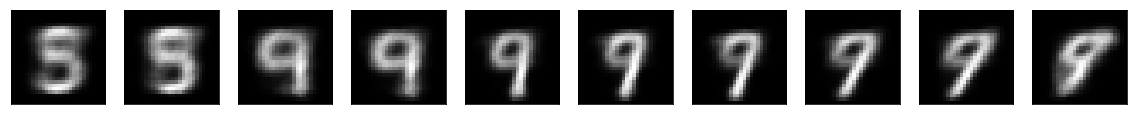

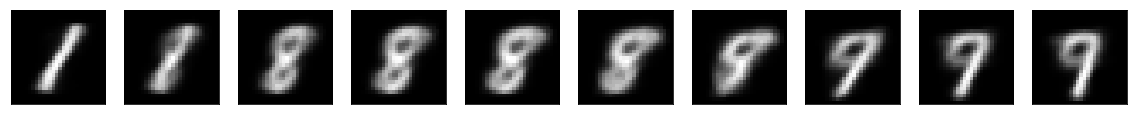

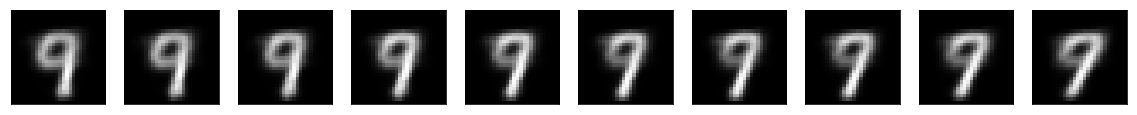

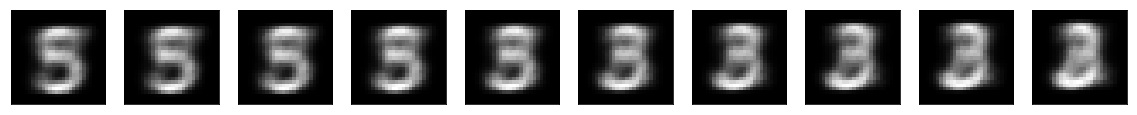

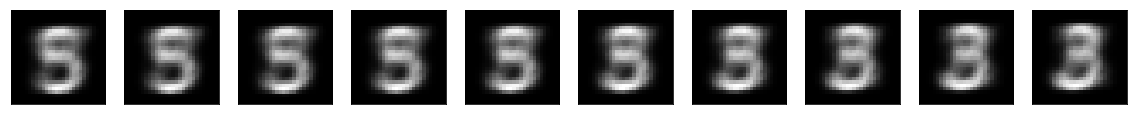

In [26]:
%matplotlib inline

n_interpolations = 5

for step, (x, y) in enumerate(train_loader):
    if step > n_interpolations:
        break
    
    x_a = x[0, :]
    x_b = x[1, :]
    
    mu_a, var_a = autoencoder.encode(x_a)
    z_a = autoencoder.reparametrize(mu_a, var_a)
    mu_b, var_b = autoencoder.encode(x_b)
    z_b = autoencoder.reparametrize(mu_b, var_b)
    
    x_interpolated = []
    
    for i, alpha in enumerate(np.linspace(0, 1, 10)):
        z_int = (1 - alpha) * z_a + alpha * z_b # interpolate in the latent space
        x_int = autoencoder.decode(z_int) # decode the interpolated sample
        
        x_interpolated.append(x_int)
    
    x_interpolated = torch.stack(x_interpolated, dim=0)
    
    plot_digits(x_interpolated)